In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics 
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving steam_raw.csv to steam_raw (1).csv


In [0]:
df = pd.read_csv('./steam_raw.csv')

In [106]:
# remove unwanted columns
to_drop = ['appid', 'name', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'genres', 'steamspy_tags']
df.drop(to_drop, inplace=True, axis=1)

# remove zeros in columns
df['price'] = df['price'].astype(float)
df['achievements'] = df['achievements'].astype(float)
df['average_playtime'] = df['average_playtime'].astype(float)
df = df[df.price != 0]
#df = df[df.achievements != 0]
#df = df[df.average_playtime != 0]
df.describe()

,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000
mean,47.752396,784.935346,167.258454,117.085866,116.447767,6.712914
std,366.361743,7827.263120,3482.386936,939.620677,1068.468825,8.014336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000
25%,0.000000,6.000000,2.000000,0.000000,0.000000,2.090000
50%,8.000000,22.000000,8.000000,0.000000,0.000000,4.790000
75%,24.000000,112.000000,37.000000,0.000000,0.000000,7.490000
max,9821.000000,496184.000000,487076.000000,55204.000000,86148.000000,421.990000


In [0]:
# combine ratings
df.insert(3, 'ratings', ' ', True) 
df['ratings'] = df['positive_ratings']/(df['positive_ratings'] + df['negative_ratings'])

# remove unwanted ratings columns
to_drop = ['positive_ratings', 'negative_ratings']
df.drop(to_drop, inplace=True, axis=1)

In [0]:
# extract the year
df['release_year'] = pd.DatetimeIndex(df['release_date']).year

# remove release_date column
to_drop = ['release_date']
df.drop(to_drop, inplace=True, axis=1)

# split owners
df[['min_owners','max_owners']] = df['owners'].str.split('-',expand=True)

# calculate average yearly revenue
df.insert(8, 'avg_revenue', ' ', True) 
df['min_owners'] = df['min_owners'].astype(float)
df['max_owners'] = df['max_owners'].astype(float)
df['price'] = df['price'].astype(float)
df['release_year'] = df['release_year'].astype(float)
df['avg_revenue'] = (df['min_owners'] + df['max_owners'])/2 * df['price'] / (2020 - df['release_year'])

# remove columns
to_drop = ['release_year', 'min_owners', 'max_owners', 'owners']
df.drop(to_drop, inplace=True, axis=1)

In [0]:
# insert column for multi-player and single-player
df.insert(1, 'singleplayer', ' ', True) 
df.insert(2, 'multiplayer', ' ', True) 

# make categories lowercase
df['categories'] = df['categories'].str.lower()

# Populate columns with True/False
df['singleplayer'] = df['categories'].str.contains('single-player')
df['multiplayer'] = df['categories'].str.contains('multi-player')

# Change to binary 0/1
df['singleplayer'] = df['singleplayer'].astype(int)
df['multiplayer'] = df['multiplayer'].astype(int)

to_drop = ['categories']
df.drop(to_drop, inplace=True, axis=1)

In [0]:
# mean normalization + feature scaling
achievements_std = df['achievements'].std()
achievements_mean = df.achievements.mean()
df.achievements = (df.achievements - achievements_mean)/achievements_std

price_std = df['price'].std()
price_mean = df.price.mean()
df.price = (df.price - price_mean)/price_std

avg_playtime_std = df['average_playtime'].std()
avg_playtime_mean = df.average_playtime.mean()
df.average_playtime = (df.average_playtime - avg_playtime_mean)/avg_playtime_std

med_playtime_std = df['median_playtime'].std()
med_playtime_mean = df.median_playtime.mean()
df.median_playtime = (df.median_playtime - med_playtime_mean)/med_playtime_std

In [111]:
df.head()
#df.to_csv('steam_v1.csv')
#files.download('steam_v1.csv')

,singleplayer,multiplayer,achievements,ratings,average_playtime,median_playtime,price,avg_revenue
0,0,1,-0.130342,0.973888,18.619124,0.187701,0.059529,5.392500e+06
1,0,1,-0.130342,0.839787,0.170190,-0.050959,-0.339755,1.425000e+06
2,0,1,-0.130342,0.895648,0.074407,-0.077164,-0.339755,1.760294e+06
3,0,1,-0.130342,0.826623,0.149969,0.063223,-0.339755,1.575000e+06
4,1,1,-0.130342,0.947996,0.539488,0.279421,-0.339755,1.425000e+06


In [112]:
df.describe()

,singleplayer,multiplayer,achievements,ratings,average_playtime,median_playtime,price,avg_revenue
count,24515.000000,24515.000000,2.451500e+04,24515.000000,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04
mean,0.965980,0.178625,-3.843523e-15,0.713999,-1.726036e-14,2.397772e-14,-6.702102e-14,3.047743e+05
std,0.181284,0.383046,1.000000e+00,0.238622,1.000000e+00,1.000000e+00,1.000000e+00,5.125625e+06
min,0.000000,0.000000,-1.303422e-01,0.000000,-1.246097e-01,-1.089856e-01,-7.976848e-01,1.316667e+03
25%,1.000000,0.000000,-1.303422e-01,0.582116,-1.246097e-01,-1.089856e-01,-5.768306e-01,9.975000e+03
50%,1.000000,0.000000,-1.085059e-01,0.764706,-1.246097e-01,-1.089856e-01,-2.399343e-01,2.330000e+04
75%,1.000000,0.000000,-6.483318e-02,0.897436,-1.246097e-01,-1.089856e-01,9.696203e-02,5.905000e+04
max,1.000000,1.000000,2.667650e+01,1.000000,5.862676e+01,8.051854e+01,5.181678e+01,6.747500e+08


In [0]:
# Run this if rerunning binning

#df.hist(column='avg_revenue', bins ='auto')
to_drop = ['bins']
df.drop(to_drop, inplace=True, axis=1)

In [142]:
# Split into bins
df.insert(7, 'bins', ' ', True) 
bin_num = np.linspace(start=0,stop=31,num=32)
df.bins = pd.qcut(df.avg_revenue, q=32, labels=bin_num)
df.head()

,singleplayer,multiplayer,achievements,ratings,average_playtime,median_playtime,price,bins,avg_revenue
0,0,1,-0.130342,0.973888,18.619124,0.187701,0.059529,31.0,5.392500e+06
1,0,1,-0.130342,0.839787,0.170190,-0.050959,-0.339755,31.0,1.425000e+06
2,0,1,-0.130342,0.895648,0.074407,-0.077164,-0.339755,31.0,1.760294e+06
3,0,1,-0.130342,0.826623,0.149969,0.063223,-0.339755,31.0,1.575000e+06
4,1,1,-0.130342,0.947996,0.539488,0.279421,-0.339755,31.0,1.425000e+06


In [114]:
df.describe()

,singleplayer,multiplayer,achievements,ratings,average_playtime,median_playtime,price,avg_revenue
count,24515.000000,24515.000000,2.451500e+04,24515.000000,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04
mean,0.965980,0.178625,-3.843523e-15,0.713999,-1.726036e-14,2.397772e-14,-6.702102e-14,3.047743e+05
std,0.181284,0.383046,1.000000e+00,0.238622,1.000000e+00,1.000000e+00,1.000000e+00,5.125625e+06
min,0.000000,0.000000,-1.303422e-01,0.000000,-1.246097e-01,-1.089856e-01,-7.976848e-01,1.316667e+03
25%,1.000000,0.000000,-1.303422e-01,0.582116,-1.246097e-01,-1.089856e-01,-5.768306e-01,9.975000e+03
50%,1.000000,0.000000,-1.085059e-01,0.764706,-1.246097e-01,-1.089856e-01,-2.399343e-01,2.330000e+04
75%,1.000000,0.000000,-6.483318e-02,0.897436,-1.246097e-01,-1.089856e-01,9.696203e-02,5.905000e+04
max,1.000000,1.000000,2.667650e+01,1.000000,5.862676e+01,8.051854e+01,5.181678e+01,6.747500e+08


In [0]:
# Testing things below
df['bins'] = df['bins'].astype(int)

In [0]:
# Log

X = df[['singleplayer', 'multiplayer', 'achievements', 'ratings', 'average_playtime', 'median_playtime', 'price']].values
y = df['bins'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, shuffle='true')

# Fit to training set
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=4000)
model.fit(X_train,y_train)

# Predictions on training set
y_pred = model.predict(X_train)


In [145]:
# Accuracy

count_miss = (y_train != y_pred).sum()
print('Misclassified samples: {}'.format(count_miss))
accuracy = metrics.accuracy_score(y_train, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 16049
Accuracy: 0.18


In [100]:
count_zeros = (y_train != 0).sum()
count_zeros

14460

In [102]:
y_pred

array([2, 3, 2, ..., 2, 3, 1])

In [118]:
# Predictions on training set
y_pred_test = model.predict(X_test)

count_miss = (y_test != y_pred_test).sum()
count_miss = (y_test != y_pred_test).sum()
print('Misclassified samples: {}'.format(count_miss))
accuracy = metrics.accuracy_score(y_train, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 2085
Accuracy: 0.57


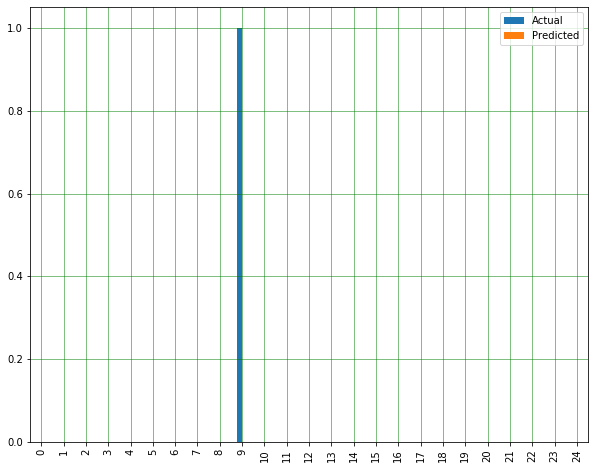

In [17]:
df1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred})
df2 = df1.head(25)

df2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [0]:
df.describe()

,singleplayer,multiplayer,achievements,ratings,average_playtime,price,avg_revenue,bins
count,3687.000000,3687.000000,3.687000e+03,3687.000000,3.687000e+03,3687.000000,3.687000e+03,3687.000000
mean,0.973691,0.244915,-1.114138e-16,0.766894,1.870321e-17,9.404950,1.539004e+06,1.141850
std,0.160073,0.430095,1.000000e+00,0.161745,1.000000e+00,8.871296,1.302187e+07,11.544916
min,0.000000,0.000000,-1.989577e-01,0.000000,-3.322793e-01,0.490000,1.354545e+03,0.000000
25%,1.000000,0.000000,-1.591700e-01,0.682075,-2.560701e-01,3.790000,3.772083e+04,0.000000
50%,1.000000,0.000000,-1.250663e-01,0.805486,-1.779067e-01,6.990000,1.310625e+05,0.000000
75%,1.000000,0.000000,-6.822675e-02,0.891304,-8.248233e-02,11.990000,5.995625e+05,0.000000
max,1.000000,1.000000,1.400809e+01,1.000000,3.562481e+01,54.990000,6.747500e+08,599.000000
